<a href="https://colab.research.google.com/github/Kanak-Dahal/Projects/blob/main/iv_surface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction


In options markets, the implied volatility (IV) surface encapsulates market expectations about future price fluctuations across different strikes and maturities. This project constructs and visualizes a smooth IV surface for the S&P 500 Index (^SPX) by retrieving live option‐chain data, computing per‐contract implied volatilities via a Newton–Raphson solver applied to the Black–Scholes‑Merton formula, and then interpolating and smoothing the resulting point‐cloud into a continuous three‑dimensional grid. The exercise demonstrates both the technical mechanics of IV extraction and the practical considerations—such as data sparsity, outlier clipping, and the choice of interpolation scheme—required to produce a clean, interpretable surface.

In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm

In [ ]:
ticker = yf.Ticker("^SPX")
all_calls = []
for expiry in ticker.options:
    calls = ticker.option_chain(expiry).calls.copy()
    calls["expiry"] = pd.to_datetime(expiry)
    all_calls.append(calls)


Before delving into volatility measures, it is instructive to examine the raw price history of the S&P 500.

 The plot of daily closing values from 2020 through mid‑2025 reveals a clear uptrend overall, punctuated by distinct phases of drawdown and recovery.
Early on, prices climbed steadily from the low‑3000s into the high‑4000s, only to retreat sharply during mid‑2022 as market sentiment shifted. This correction bottomed out near 3500 before a renewed rally carried the index through successive all‑time highs above 6500 by mid‑2025. The cyclical nature of these moves underscores the importance of conditioning volatility forecasts on regime shifts: periods of rising prices tend to coincide with relatively low realized volatility, while corrections and panics produce sharp spikes in both realized and implied measures.

Viewing the underlying price dynamics alongside our IV surface and GARCH estimates provides essential context for interpreting how market risk aversion and realized shocks evolve across bull and bear phases.


In [ ]:
close_prices = ticker.history(period="5y")['Close']
close_prices = close_prices.dropna()
close_prices

Date
2020-07-20 00:00:00-04:00    3251.840088
2020-07-21 00:00:00-04:00    3257.300049
2020-07-22 00:00:00-04:00    3276.020020
2020-07-23 00:00:00-04:00    3235.659912
2020-07-24 00:00:00-04:00    3215.629883
                                ...     
2025-07-14 00:00:00-04:00    6268.560059
2025-07-15 00:00:00-04:00    6243.759766
2025-07-16 00:00:00-04:00    6263.700195
2025-07-17 00:00:00-04:00    6297.359863
2025-07-18 00:00:00-04:00    6296.790039
Name: Close, Length: 1256, dtype: float64

Plotting the SPX close prices overtime


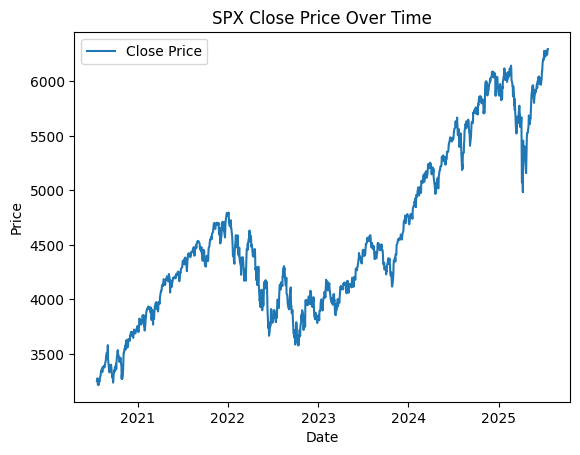

In [ ]:
plt.plot(close_prices.index, close_prices.values, label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SPX Close Price Over Time')
plt.legend()
plt.show()

In [ ]:
expriry = ticker.options[4]
option_chain = ticker.option_chain(expriry)
calls = option_chain.calls
puts = option_chain.puts

Next we visualise how the open interests change w.r.t. strike pricces

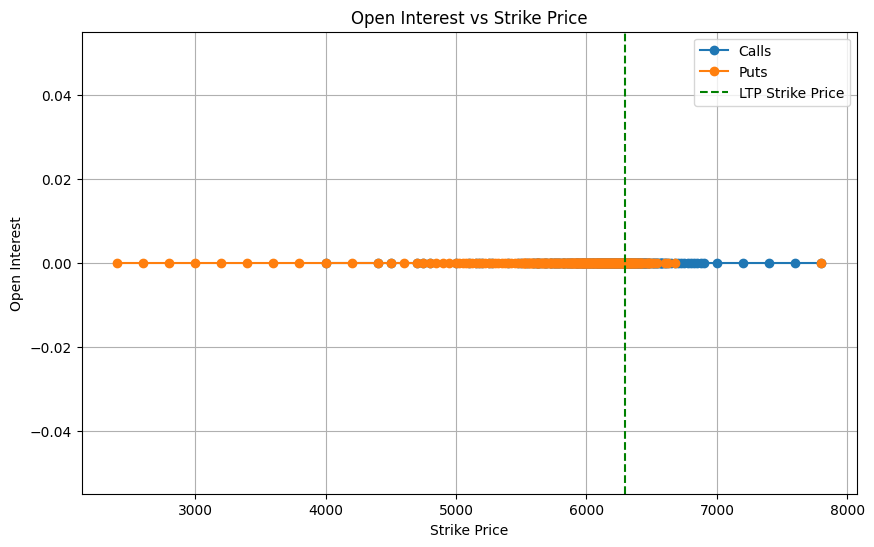

In [ ]:
ltp = ticker.history(period="1d")['Close'].iloc[-1]
plt.figure(figsize=(10, 6))
plt.plot(calls['strike'], calls['openInterest'], marker='o', linestyle='-', label='Calls')
plt.plot(puts['strike'], puts['openInterest'], marker='o', linestyle='-', label='Puts')

plt.axvline(x=ltp, color='g', linestyle='--', label='LTP Strike Price')
plt.title('Open Interest vs Strike Price')
plt.xlabel('Strike Price')
plt.ylabel('Open Interest')
plt.legend()
plt.grid()
plt.show()

This chart plots, for a single expiry, the open interest in calls (blue) and puts (orange) at each strike price, with the underlying’s current level marked by the green dashed line. Open interest measures how many option contracts remain outstanding, so its distribution across strikes tells you where the bulk of market positions lie. In most liquid indices, you’ll see the highest call open interest clustered at strikes just above the current index level, reflecting traders betting on—or hedging against—upside moves, while put open interest peaks just below spot, where investors protect against downside.

Where open interest is particularly large, that strike often acts as a magnet for price action: dealers who have sold those options will dynamically hedge by trading the underlying, generating support or resistance around that level. Conversely, strikes with thin open interest may be ignored by the market. By examining this snapshot, you can infer which strikes market‐makers are most heavily committed to, anticipate potential “pinning” behavior as expiration approaches, and gauge overall liquidity in the chain.

## Volatality "Smile"/"Skew"

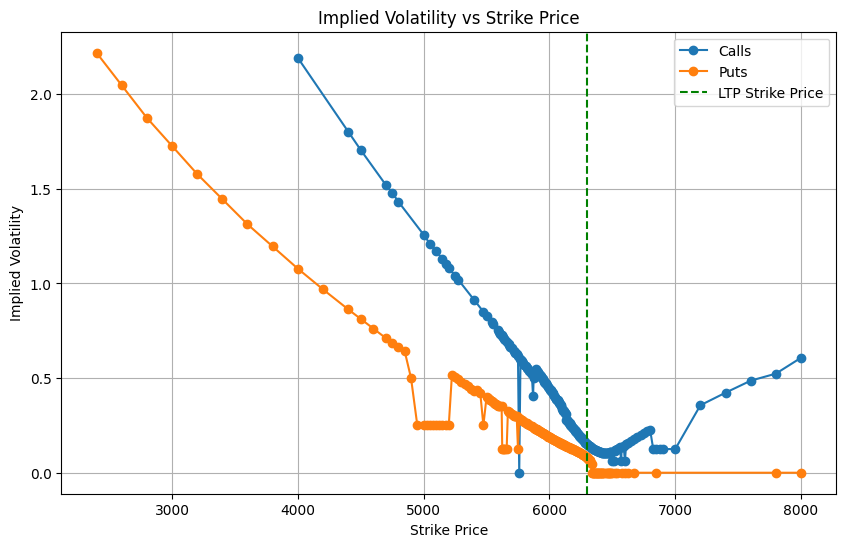

In [ ]:
### implied volatility

plt.figure(figsize=(10, 6))
plt.plot(calls['strike'], calls['impliedVolatility'], marker='o', linestyle='-', label='Calls')
plt.plot(puts['strike'], puts['impliedVolatility'], marker='o', linestyle='-', label='Puts')
plt.axvline(x=ltp, color='g', linestyle='--', label='LTP Strike Price')
plt.title('Implied Volatility vs Strike Price')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid()
plt.show()

This chart lays out the raw volatility “smile” for calls (blue) and puts (orange) across every strike in the chosen expiry, with the underlying’s last traded price flagged by the green dashed line. What immediately leaps out is the pronounced skew: implied volatilities for deep‑out‑of‑the‑money puts (left-hand side) climb well above 2.0, signaling that the market is demanding hefty premia to protect against large downward moves, whereas OTM calls hanging off to the right trade much cheaper. As you move from the far wings toward at‑the‑money strikes, both curves slope downward, but the put curve remains elevated relative to calls, reflecting asymmetric tail‑risk concerns. Around the spot strike itself, volatilities converge to a minimum before rising again slightly for small call‑OTM strikes — a subtle nod to the market’s acknowledgment of two‑sided risk close to spot. The jaggedness in the call series near the rightmost strikes simply reflects sparse quotes and occasional zero or near‑zero last prices for very far‑OTM contracts. In sum, this plot vividly illustrates how moneyness drives option pricing: downside protection carries a premium, and the market’s implied distribution is fatter on the left tail than on the right.


### Data Acquisition and Cleaning

First, we query the full list of SPX option expiries and download the calls chain for each date. By adding a computed “days_to_expiry” field, we convert calendar dates into a numeric time‑to‑maturity. To ensure stability in our implied‐volatility solver, we remove any contracts lacking a quoted last price or implied volatility, and we trim away extreme IV readings below 5 percent or above 100 percent. This filtering step eliminates stale or illiquid strikes that would otherwise introduce wild spikes or solver failures.

In [ ]:
df = pd.concat(all_calls)
df['days_to_expiry'] = (df['expiry'] - pd.Timestamp.today()).dt.days


df = df.drop(columns=['contractSymbol','lastTradeDate','inTheMoney','contractSize','currency'])
df = df.dropna(subset=['impliedVolatility'])
df = df[(df['impliedVolatility'] > 0.05) & (df['impliedVolatility'] < 1)]

At the heart of this landscape lies the concept of implied volatility (σ
imp
​
 ). Unlike historical volatility, which retrospectively quantifies past price movements, implied volatility is a forward-looking measure. It represents the market's consensus forecast of the annualized standard deviation of the underlying asset's returns, specifically for the SPX Index, over the remaining life of an option contract. When one observes the current market price of an option, denoted as C
mkt
​
 , this price is the observable outcome of countless investors' beliefs about future uncertainty.

The extraction of this σ
imp
​
  is a sophisticated inverse problem, typically solved by leveraging the renowned Black-Scholes-Merton option pricing model for European-style call options. The theoretical price of a European call option (C*BS*
​
 ) is given by the formula:

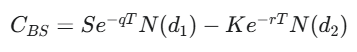




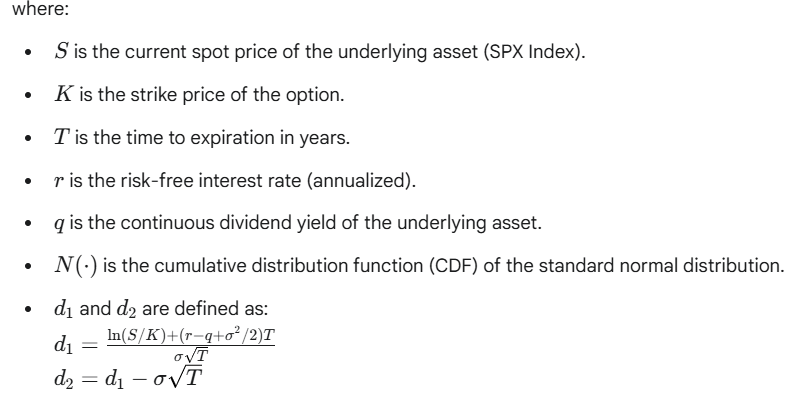

In this framework, σ represents the volatility of the underlying asset. The implied volatility, σ
imp
​
 , is precisely that value of σ which, when plugged into the Black-Scholes formula, equates the theoretical price C
BS
​
  to the observed market price C
mkt
​
 . That is, we seek σ
imp
​
  such that C
BS
​
 (σ
imp
​
 )=C
mkt
​
 . Since the Black-Scholes equation cannot be rearranged algebraically to solve directly for σ, numerical methods (such as Newton-Raphson or bisection algorithms) are employed to iteratively find this root. This iterative process is crucial as the option's market price implicitly contains the market's forward-looking volatility expectation.

In [ ]:
def historical_volatility(prices, window=30):
    log_returns = np.log(prices / prices.shift(1))
    volatility = log_returns.rolling(window=window).std() * np.sqrt(252)  # Annualize
    return volatility


def bsm_price(s, k, T, r, sigma, q=0):
    d1 = (np.log(s/k)+(r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    call = s*np.exp(-q*T)*norm.cdf(d1) - k*np.exp(-r*T)*norm.cdf(d2)
    return call

def option_vega(s, k, T, r, sigma, q=0):
    d1 = (np.log(s/k)+(r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return s*np.exp(-q*T)*norm.pdf(d1)*np.sqrt(T)

def implied_vol(s, k, T, r, market_price, q=0, tol=1e-6, max_iter=100):
    sigma = 0.2
    for i in range(max_iter):
        price = bsm_price(s, k, T, r, sigma, q)
        diff = price - market_price
        if abs(diff) < tol:
            return sigma
        sigma -= diff/option_vega(s, k, T, r, sigma, q)
        sigma = max(sigma, 1e-6)
    return sigma

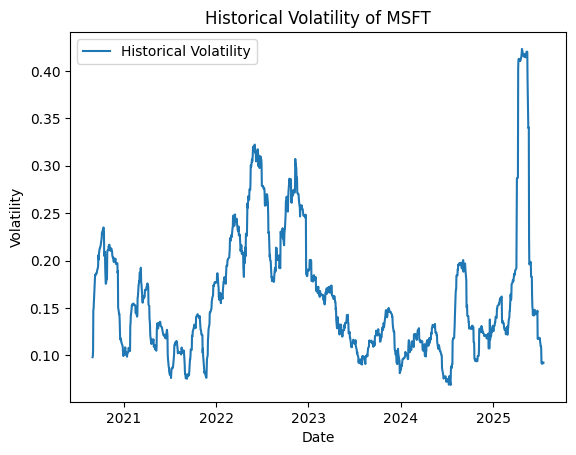

In [ ]:
plt.plot(close_prices.index, historical_volatility(close_prices, window=30), label='Historical Volatility')
plt.title('Historical Volatility of MSFT')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

Historical volatility represents the actual, realized fluctuation of an asset’s price over a past window of time. In our notebook, we compute it by taking rolling log‐returns—specifically the natural logarithm of each day’s close divided by the prior day’s close—and then measuring their standard deviation over a fixed lookback period (e.g. 30 trading days). Multiplying that rolling standard deviation by the square root of 252 annualizes the series, translating daily variability into an annual percentage figure comparable to implied volatilities.

Before the implied volatility can be extracted, the raw options data must be meticulously prepared and transformed into the precise inputs required by the Black-Scholes model.

**Time to Expiry (T):** This crucial input is calculated as the difference between the option's expiry date and the current date, normalized to an annual basis. Mathematically, if Δt is the number of calendar days until expiration, then T=
365
Δt
​
 . This ensures consistency with annualized rates used in the model.

**Moneyness:** While not a direct input to Black-Scholes, moneyness is a critical descriptive variable for analyzing the shape of the volatility surface. It is typically defined as the ratio of the strike price to the current underlying spot price, i.e.,  
S
K
​
 . Options are classified as in-the-money (K/S<1 for calls), at-the-money (K/S≈1), or out-of-the-money (K/S>1 for calls). This normalization allows for a more consistent comparison of options across different underlying price levels.


 **Filtering and Refinement:** Data integrity dictates the removal of options with missing market prices (C
mkt
​
 ) or those whose prices are inconsistent with the Black-Scholes framework (e.g., violating put-call parity or having very low liquidity). Furthermore, options with extremely short (T→0) or excessively long (T→∞) expirations, or those deep in/out-of-the-money, may be filtered to ensure the stability and representativeness of the calculated σ
imp
​
  values. The accurate determination of the risk-free rate (r) and dividend yield (q) is also paramount, as these parameters directly influence the d
1
​
  and d
2
​
  calculations.

In [ ]:
spot = ticker.history(period='1d')['Close'].iloc[-1]
R = 0.0444

# Compute IV across strikes and expiries
records = []
for _, row in df.iterrows():
    T = row.days_to_expiry/365
    iv = implied_vol(spot, row.strike, T, R, row.lastPrice)
    records.append((row.strike, row.days_to_expiry, iv))

C:\Users\asus\AppData\Local\Temp\ipykernel_29068\4042789723.py:8: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(s/k)+(r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
C:\Users\asus\AppData\Local\Temp\ipykernel_29068\4042789723.py:9: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma*np.sqrt(T)
C:\Users\asus\AppData\Local\Temp\ipykernel_29068\4042789723.py:14: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(s/k)+(r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
C:\Users\asus\AppData\Local\Temp\ipykernel_29068\4042789723.py:15: RuntimeWarning: invalid value encountered in sqrt
  return s*np.exp(-q*T)*norm.pdf(d1)*np.sqrt(T)
C:\Users\asus\AppData\Local\Temp\ipykernel_29068\4042789723.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(s/k)+(r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
C:\Users\asus\AppData\Local\Temp\ipykernel_29068\4042789723.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (n

In [ ]:
iv_df = pd.DataFrame(records, columns=['strike','days_to_expiry','implied_vol'])
# Keep only positive T
iv_df = iv_df[iv_df.days_to_expiry>0]

### Gaussian Smoothing and Clipping
Even after interpolation, small oscillations and residual noise can remain. We therefore apply a light Gaussian filter to the gridded surface, gently blurring adjacent cells while preserving the overall shape of the skew and term‐structure. Prior to visualization, we also clip the smoothed IV values to lie within economically sensible bounds, ensuring that outliers cannot dominate the color scale or vertical axis.

In [ ]:
pivot = iv_df.pivot_table(
    index='strike', columns='days_to_expiry', values='implied_vol', aggfunc='mean'
)
# Sort axes
pivot = pivot.sort_index(axis=0).sort_index(axis=1)
# Interpolate missing
pivot = pivot.interpolate(axis=0, method='linear').interpolate(axis=1, method='linear')
# Clip extremes
pivot = pivot.clip(lower=0.05, upper=0.8)

### Visualization of the Smoothed Surface
With a fully defined Z‑grid of implied volatility over strikes and days‑to‑expiry, we render a three‑dimensional plot using Matplotlib’s surface routine. The choice of a continuous colormap highlights the gradual transition from short‑dated, steep‐skew IV profiles to longer‐dated, flatter volatility regimes. Axes labels and a colorbar provide quantitative context, while stride parameters ensure that the mesh remains fine enough to capture curvature yet coarse enough to display legibly.

C:\Users\asus\AppData\Local\Temp\ipykernel_29068\4042789723.py:8: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(s/k)+(r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
C:\Users\asus\AppData\Local\Temp\ipykernel_29068\4042789723.py:9: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma*np.sqrt(T)
C:\Users\asus\AppData\Local\Temp\ipykernel_29068\4042789723.py:14: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(s/k)+(r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
C:\Users\asus\AppData\Local\Temp\ipykernel_29068\4042789723.py:15: RuntimeWarning: invalid value encountered in sqrt
  return s*np.exp(-q*T)*norm.pdf(d1)*np.sqrt(T)
C:\Users\asus\AppData\Local\Temp\ipykernel_29068\4042789723.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(s/k)+(r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
C:\Users\asus\AppData\Local\Temp\ipykernel_29068\4042789723.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (n

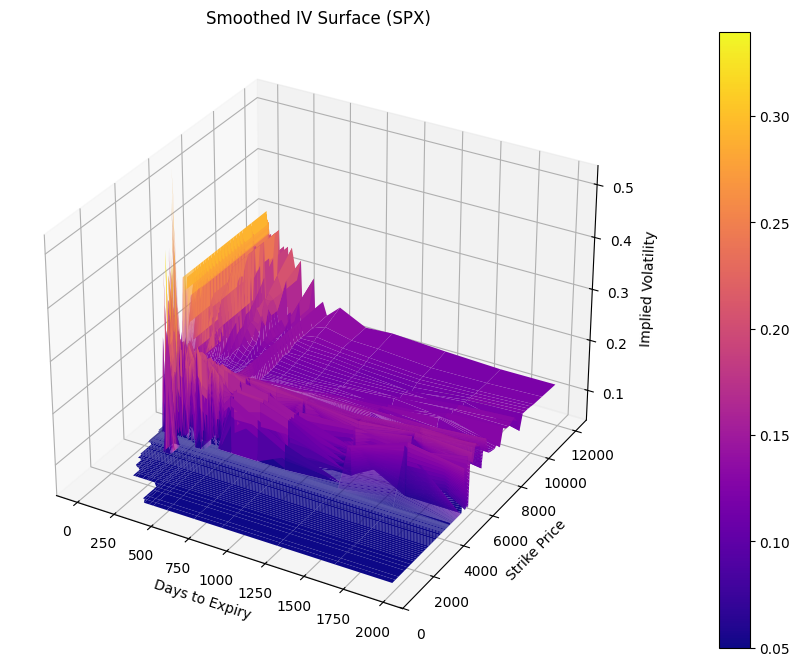

In [ ]:
days = pivot.columns.values
strikes = pivot.index.values
X, Y = np.meshgrid(days, strikes)
Z = pivot.values

# Plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    X, Y, Z, cmap='plasma', rstride=1, cstride=1, antialiased=True, linewidth=0
)
ax.set_xlabel('Days to Expiry')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Implied Volatility')
ax.set_title('Smoothed IV Surface (SPX)')
fig.colorbar(surf, pad=0.1)
plt.show()

### Interpretation and Extensions
The resulting IV surface exhibits the familiar “smile” or “smirk” across strikes—reflecting heavier tails in the underlying’s distribution—and the typical upward tilt of volatility for longer maturities. Analysts can slice the surface at fixed maturities to examine cross‑sectional skew dynamics, or at fixed strikes to observe how term structure evolves. Future extensions might include fitting parametric forms (e.g., SVI) to the smoothed surface for integration into trading models, or repeating the procedure daily to generate a time series of surface parameters for risk management and forecasting.


The construction and interpretation of the implied volatility surface are not mere academic exercises; they hold profound significance for anyone navigating the complex world of options and risk, providing a robust quantitative foundation for decision-making.

Precision Pricing: It enables more accurate pricing of complex, exotic derivatives that cannot be valued with simple models, as it provides a richer, more realistic input for future volatility, moving beyond a single, constant σ.

Strategic Trading: For traders, the surface is a treasure map. Deviations from the established surface, where an option's market price implies a volatility significantly different from its neighbors on the surface, can signal mispricings. This allows for the construction of sophisticated options strategies that capitalize on anticipated changes in the shape of the volatility surface or specific market skew.

Robust Risk Management: Risk managers utilize the surface to gauge overall market stress, identify potential areas of systemic vulnerability, and construct more effective hedging strategies. Understanding where volatility is "sticky" or "cheap" across strikes and maturities is crucial for portfolio protection and Value-at-Risk (VaR) calculations.

Market Sentiment Barometer: Ultimately, the implied volatility surface serves as a real-time, quantitatively derived barometer of collective investor expectations and fear. Its dynamic shifts reflect the market's reaction to economic data releases, geopolitical events, and corporate news, providing a powerful diagnostic tool for understanding the prevailing mood and anticipating future market movements, thereby offering insights into the market's perceived probability distributions of future asset prices.

In this section, we transform the raw SPX closing prices into a series of daily log-returns and their squares in preparation for volatility modeling. By taking the natural logarithm of each day’s close divided by the previous day’s close—and multiplying by 100—we obtain a percentage‐scale, continuously compounded return that is symmetric for gains and losses and well suited for time‐series analysis. Squaring these log‐returns then gives us a measure of realized variance on each day, which the GARCH model will use to capture clustering in volatility: large squared returns signal high‐volatility regimes, while small values reflect calmer periods.

In [ ]:
log_returns = np.log(close_prices / close_prices.shift(1))*100
sq_log_returns = ((log_returns/100)**2) * 100
sq_log_returns = sq_log_returns.dropna()
log_returns = log_returns.dropna()
log_returns

Date
2020-07-21 00:00:00-04:00    0.167763
2020-07-22 00:00:00-04:00    0.573063
2020-07-23 00:00:00-04:00   -1.239638
2020-07-24 00:00:00-04:00   -0.620964
2020-07-27 00:00:00-04:00    0.736793
                               ...   
2025-07-14 00:00:00-04:00    0.140642
2025-07-15 00:00:00-04:00   -0.396415
2025-07-16 00:00:00-04:00    0.318857
2025-07-17 00:00:00-04:00    0.535938
2025-07-18 00:00:00-04:00   -0.009049
Name: Close, Length: 1255, dtype: float64

Visualising how the log returns look like

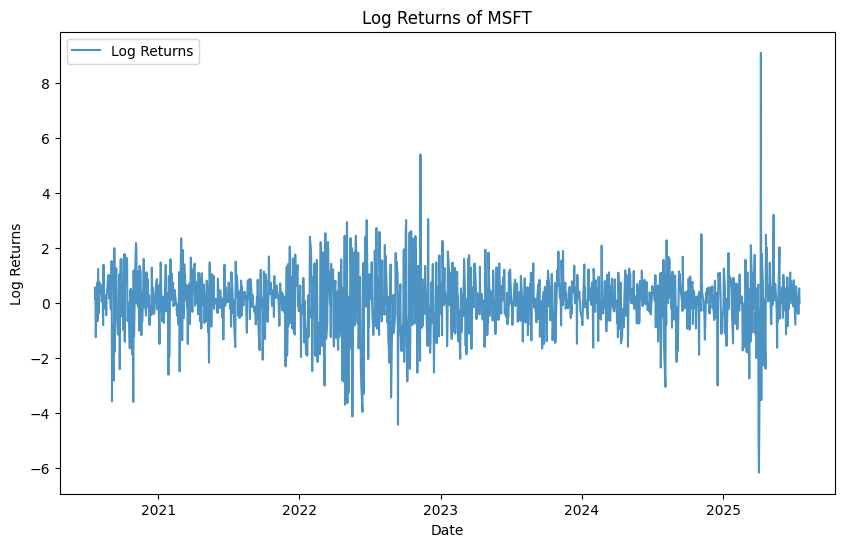

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(log_returns.index, log_returns, label='Log Returns', alpha=0.8)
plt.title('Log Returns of MSFT')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

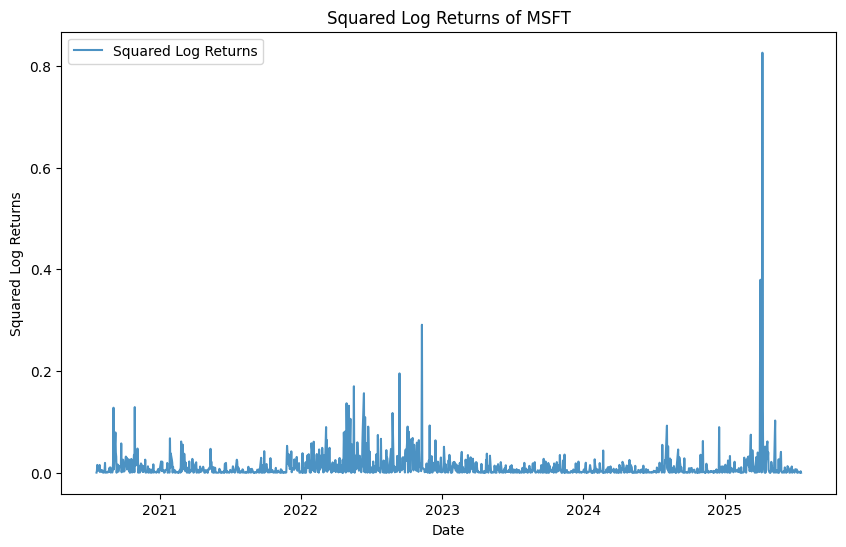

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(log_returns.index, sq_log_returns, label='Squared Log Returns', alpha=0.8)
plt.title('Squared Log Returns of MSFT')
plt.xlabel('Date')
plt.ylabel('Squared Log Returns')
plt.legend()
plt.show()

ARCH Test, PACF and ACF plots

ARCH Test p-value: 1.3447585755633156e-28


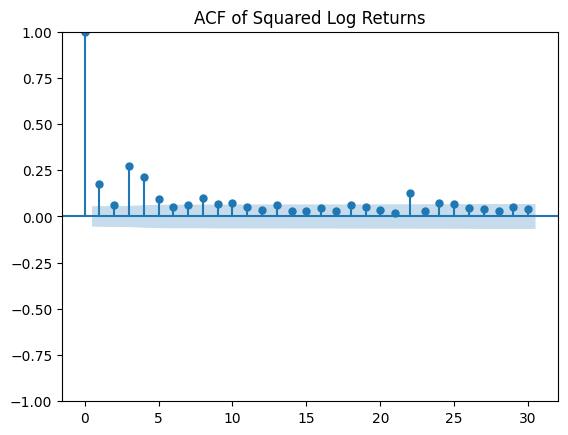

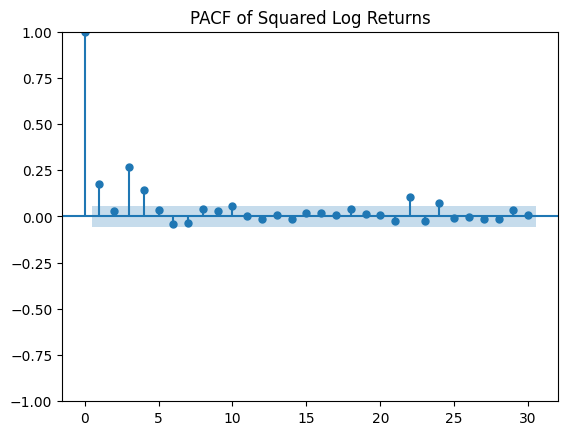

In [ ]:
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARCH Test for volatility clustering
arch_test_result = het_arch(log_returns)
print("ARCH Test p-value:", arch_test_result[1])

# ACF/PACF plots of squared returns
plot_acf(sq_log_returns, lags=30)
plt.title("ACF of Squared Log Returns")
plt.show()

plot_pacf(sq_log_returns, lags=30)
plt.title("PACF of Squared Log Returns")
plt.show()


# The Garch Framework

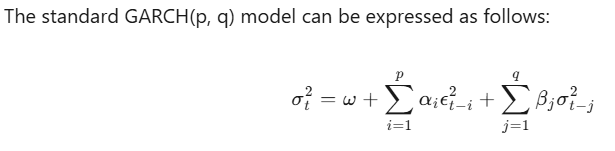

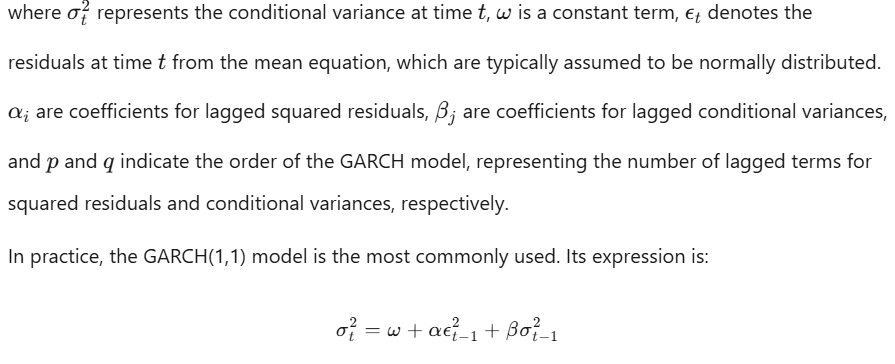

### **Key Assumptions and Properties**



**Volatility Clustering:** GARCH models assume that large price changes (either upward or downward) will be followed by large changes of either sign, a common characteristic of financial time series.


**Mean Reversion:** The models assume that volatility will revert to a long-term average over time, a behavior observed in many financial market volatilities.

**Positive Conditional Variance:** The conditional variance σ*t* squared
     must always be positive. In the GARCH model, the parameters ω, α
​
 , and β
​
  are restricted to non-negative values to ensure this.

**Stationarity:** For a GARCH model to yield meaningful and stable long-term forecasts, the time series must be stationary. Generally, the sum of α
i
​
  and β
j
​
  must be less than 1. For the GARCH(1,1) model, the condition α+β<1 must hold.



In [ ]:
from arch import arch_model

am = arch_model(log_returns, vol='Garch', p=1, q=1)
res = am.fit(update_freq=5, disp="off")
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1755.17
Distribution:                  Normal   AIC:                           3518.35
Method:            Maximum Likelihood   BIC:                           3538.89
                                        No. Observations:                 1255
Date:                Mon, Jul 21 2025   Df Residuals:                     1254
Time:                        14:47:39   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0814  2.472e-02      3.294  9.872e-04 [3.299e-0

The mean model component reveals a statistically significant mean value of approximately 0.0814, with a p-value of 9.87 × 10⁻⁴ indicating its significance. The R-squared value of 0.000 suggests that the constant mean model does not explain any of the variation in the data, which is typical for GARCH models that focus primarily on volatility rather than the mean. The 95% confidence interval for the mean coefficient is [0.03299, 0.130], providing a range within which the true mean is likely to fall.


Turning to the volatility model, the GARCH(1,1) specification includes three key parameters: omega (ω), alpha (α₁), and beta (β₁). The omega coefficient is estimated at 0.0401 with a standard error of 0.01593, resulting in a t-statistic of 2.516 and a p-value of 1.186 × 10⁻², indicating statistical significance. This represents the long-run average volatility or the unconditional variance of the series. The alpha coefficient is 0.1209 with a standard error of 0.02866, yielding a highly significant t-statistic of 4.218 and a p-value of 2.467 × 10⁻⁵. This parameter captures the impact of recent shocks (lagged squared residuals) on current volatility, suggesting that approximately 12.09% of volatility is explained by the most recent squared shock. The beta coefficient is 0.8463 with a standard error of 0.03441, resulting in an extremely significant t-statistic of 24.596 and a p-value effectively equal to zero. Beta represents the persistence of volatility, indicating how much of the previous period's volatility carries over to the current period.


The sum of alpha and beta coefficients (0.1209 + 0.8463 ≈ 0.967) reveals a high degree of volatility persistence, implying that shocks to volatility decay very slowly over time. This is characteristic of financial time series, where volatility tends to cluster and exhibit long-lasting effects. The half-life of volatility shocks can be approximated as ln(0.5)/ln(0.967) ≈ 22 periods, indicating it would take approximately 33 periods for a shock to fully dissipate. The model's log-likelihood is -1755.17, with information criteria values of 3518.35 for AIC and 3538.89 for BIC, which can be used to compare the fit of this model against others.


The normal distribution assumption for the residuals is worth noting, as financial returns often exhibit fat tails and may not strictly follow a normal distribution. This could potentially limit the model's accuracy in capturing extreme events. Overall, the GARCH(1,1) model effectively captures the volatility clustering and persistence in the data. The high beta coefficient underscores the long memory in volatility, while the significant alpha coefficient indicates responsiveness to new information.

Visualising the Conditional Volatality

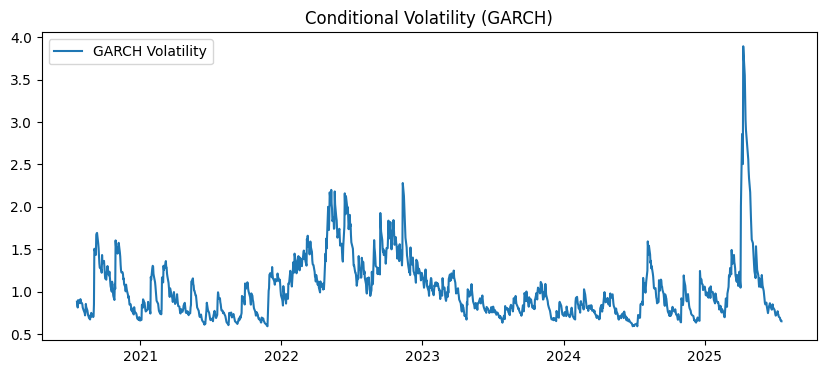

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(res.conditional_volatility, label='GARCH Volatility')
plt.title('Conditional Volatility (GARCH)')
plt.legend()
plt.show()

The graph illustrates the conditional volatility of a time series as modeled by a GARCH model over several years, from 2021 to 2025.

The volatility, represented by the blue line, shows fluctuations over time, indicating varying levels of uncertainty or risk in the data. Starting in 2021, the volatility appears to be relatively low but shows some upward movement. It continues to increase gradually through 2022 and 2023, reaching higher levels in 2023. This upward trend could be indicative of increasing uncertainty or instability in the underlying process during this period.

Moving into 2024, there's a noticeable dip in volatility, suggesting a period of relative calm or decreased uncertainty. However, this calm is followed by a sharp spike in volatility in 2025. This sudden increase could be due to a significant event or shock impacting the data, leading to heightened volatility.

Forecasting the Annual Volatality

In [ ]:
forecast_horizon = 5
forecasts = res.forecast(horizon=forecast_horizon)
last_historical_date = log_returns.index[-1]

forecast_dates = pd.date_range(start=last_historical_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')
annualized_volatility_forecasts = []
for i in range(forecast_horizon):

    daily_variance_forecast = forecasts.variance.iloc[-1, i] / (100**2)
    annualized_vol = np.sqrt(daily_variance_forecast * 252) * 100
    annualized_volatility_forecasts.append(annualized_vol)

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Annualized_Volatility_Forecast (%)': annualized_volatility_forecasts
})

print("\n--- Volatility Forecast (Annualized) ---")
print(forecast_df.to_string(index=False))


--- Volatility Forecast (Annualized) ---
                     Date  Annualized_Volatility_Forecast (%)
2025-07-21 00:00:00-04:00                           10.045219
2025-07-22 00:00:00-04:00                           10.378047
2025-07-23 00:00:00-04:00                           10.690117
2025-07-24 00:00:00-04:00                           10.983529
2025-07-25 00:00:00-04:00                           11.260055


The output shows the annualized volatility forecasts for each day from 2025-07-21 to 2025-07-25. The values are as follows:
2025-07-21: 10.045%


* 2025-07-22: 10.378%
* 2025-07-23: 10.690%
* 2025-07-24: 10.983%
* 2025-07-25: 11.260%


These values indicate the model's prediction of increasing volatility over the 5-day forecast horizon. This could be due to the model capturing recent trends or shocks in the data that suggest volatility is rising. The increasing forecasts might also reflect the persistence parameter (β) in the GARCH model, which indicates that volatility shocks tend to have a lasting impact.

Considerations

 1. Annualization Factor: The use of 252 assumes the data is daily and relates to trading days in a year. This is standard for financial markets but should be adjusted if the data frequency or market trading days differ.

 2. Model Assumptions: The forecast relies on the GARCH model's ability to accurately capture the volatility dynamics. If the model assumptions (such as normality of residuals) are violated, the forecast accuracy might be affected.

 3. Uncertainty: Volatility forecasts from GARCH models are subject to uncertainty, and the confidence intervals around these forecasts could provide additional insight into the range of possible volatility outcomes. However, the code provided does not include the calculation or display of these intervals.